Assuming we have a finite number of reads, how will the organisms at different abundances be represented?  
For example, assume 2 organisms at the following abundances based on cell copy number:

||abundance (haploid genomes)|
|:-|:-:|
|*B. subtilis*|250|
|*E. coli*|500|

Where *B. subtilis* contributes 250 haploid cells and *E. coli* contributes 500 haploid cells.

**Working from the beginning community digest to flow-cell binding, how can a discrete number of reads be split between these two organisms?**

### Digestion

Assuming infinite fragments and no size preference, the probability of a given fragment being produced in a restriction enzyme digest can be estimated by considering the joint probability of the digestion occuring on both terminal ends and not occuring in any internal cut sites, if present.

$P(fragment) = P(cut)^2 * (1-P(cut)^{internals})$

This assumes independence of cut events and assigns a probability to each fragment within the anticipated range of fragment lengths. The summed probabilities of all fragments of this set approximate the number of reads produced from one haploid genome, again within the anticipated range of fragment lengths (typically between 1bp and (mean + 6sd)bp).

### Merging organisms

Previously, the independence of site digestion within an individual organism's genome has been assumed. As each genome is digested separately *in-silico*, it is also assumed the total fragments produced by one genome will be independent from another and dependent on genome size and motif frequency.

In order to combine the separate organisms together, we must consider the partial contribution of each organism towards the total input abundance. To do this, we first multiply the existing per-fragment probabilities by the percent composition. Then, we create a summary dictionary for each fragment length across all organisms in our community that uses cumulative probability as a weight. This summary object encompasses the fragment length distribution we would expect if all samples were prepared together as a mixture.

Following a size-selection rule, such as the intersection of a defined distribution of fragments, we then calculate the frequency of each fragment length as a per-length probability density. These density values are applied to the original digested fragment probabilities for each individual organism.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
df_b = pd.read_csv('../tests/test_project6/B_output/copies_Bacillus_subtilis_complete_genome.fasta.csv')
df_e = pd.read_csv('../tests/test_project6/E_output/copies_Escherichia_coli_complete_genome.fasta.csv')

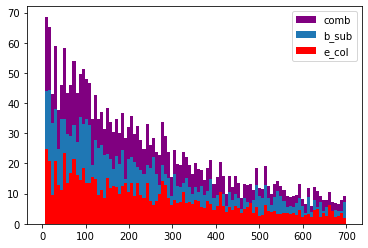

In [2]:
fragments_freq_b = {}

for i in range(0, max(df_b['length'])+1):
    fragments_freq_b[i] = df_b[df_b['length'] == i]['probability'].sum()

fragments_freq_e = {}

for i in range(0, max(df_e['length'])+1):
    fragments_freq_e[i] = df_e[df_e['length'] == i]['probability'].sum()

fragments_freq = {i:fragments_freq_b[i]+fragments_freq_e[i] for i in range(0, 701)}

plt.hist(fragments_freq.keys(), weights=fragments_freq.values(), density=False, histtype='bar', color='purple', bins=100, label='comb')
plt.hist(fragments_freq_b.keys(), weights=fragments_freq_b.values(), density=False, histtype='bar', bins=100, label='b_sub')
plt.hist(fragments_freq_e.keys(), weights=fragments_freq_e.values(), density=False, histtype='bar', color='red', bins=100, label='e_col')
plt.legend()
plt.show()

<AxesSubplot:xlabel='0', ylabel='Count'>

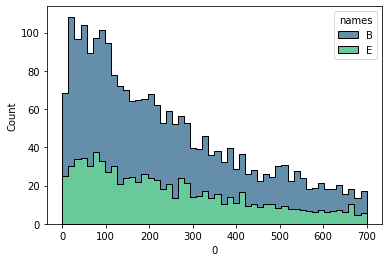

In [13]:
test_df1 = pd.DataFrame(fragments_freq_b.items())
test_df1['names'] = 'B'
test_df2 = pd.DataFrame(fragments_freq_e.items())
test_df2['names'] = 'E'
test_df = pd.concat([test_df1, test_df2], axis=0)

sns.histplot(data=test_df, x=test_df[0], hue=test_df['names'], weights=test_df[1], palette="viridis", multiple="stack", bins=50, element="step")
# sns.histplot(data=test_df, x=test_df[0], hue=test_df['names'], weights=test_df[1], palette="viridis", multiple="stack", bins=100, element="step")

In [3]:
abundances = np.array([250, 500])
abundances = abundances / abundances.sum()
abundances

array([0.33333333, 0.66666667])

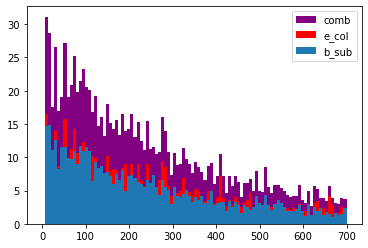

In [4]:
df_b['probability'] = df_b['probability'] * abundances[0]
df_e['probability'] = df_e['probability'] * abundances[1]


fragments_freq_b = {}

for i in range(0, max(df_b['length'])+1):
    fragments_freq_b[i] = df_b[df_b['length'] == i]['probability'].sum()

fragments_freq_e = {}

for i in range(0, max(df_e['length'])+1):
    fragments_freq_e[i] = df_e[df_e['length'] == i]['probability'].sum()

fragments_freq = {i:fragments_freq_b[i]+fragments_freq_e[i] for i in range(0, 701)}

plt.hist(fragments_freq.keys(), weights=fragments_freq.values(), density=False, histtype='bar', color='purple', bins=100, label='comb')
plt.hist(fragments_freq_e.keys(), weights=fragments_freq_e.values(), density=False, histtype='bar', color='red', bins=100, label='e_col')
plt.hist(fragments_freq_b.keys(), weights=fragments_freq_b.values(), density=False, histtype='bar', bins=100, label='b_sub')
plt.legend()
plt.show()

In [12]:
def gauss_pdf(mean, sd, x):
    '''
    return the probability density of x from a normal distribution
    note: the sum of pdf for all points x = 1
    '''
    pdf = (1/sd*np.sqrt(2*np.pi))*np.exp((-1/2)*((x-mean)/sd)**2)
    return pdf

def get_draw_dict(mean, sd, len_dt, scale_by):
    '''
    create a dictionary of draw numbers
    '''
    draw_dt = {}

    for x in range(0, mean + 6*sd + 1):
        draw_counts = gauss_pdf(mean, sd, x)*scale_by
        data_counts = len_dt[x]
        draw_dt[x] = min(draw_counts, data_counts)*0.65 #TODO average recovery

    return draw_dt

In [11]:
len_dt = fragments_freq
a = [len_dt[i] for i in range(400, (500+(500-400))+1)]
avg_upper = sum(a)/len(a)
scale_by = avg_upper/gauss_pdf(400, 50, 500)
draw_dt = get_draw_dict(400, 50, len_dt, scale_by)

NameError: name 'fragments_freq' is not defined

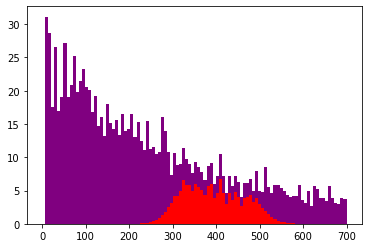

In [6]:
plt.hist(fragments_freq.keys(), weights=fragments_freq.values(), density=False, histtype='bar', color='purple', bins=100, stacked=True)
plt.hist(draw_dt.keys(), weights=draw_dt.values(), density=False, histtype='bar', color='red', bins=100, stacked=True)
plt.show()

<ipython-input-7-680c85dcfedb>:4: RuntimeWarning: invalid value encountered in double_scalars
  fragment_comps[i] = draw_dt[i] / fragments_freq[i]


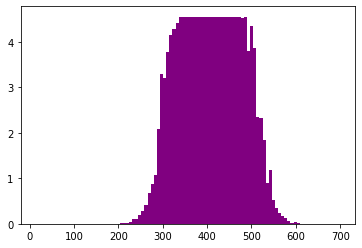

In [7]:
fragment_comps = {}

for i in range(0, 701):
    fragment_comps[i] = draw_dt[i] / fragments_freq[i]

plt.hist(fragment_comps.keys(), weights=fragment_comps.values(), density=False, histtype='bar', color='purple', bins=100, stacked=True)
plt.show()

In [8]:
df_e['test'] = df_e['length'].map(fragment_comps)
df_e['test'] = df_e['test'] * df_e['probability']

df_e[df_e['length']==500]

,seq,start,end,m1,m2,internal,length,reverse,probability,test
2378,CATGGATCCAGTATCAGGGATTCAAAACCGAAATCGACAAACACAT...,1128114,1128608,CATG,GAATTC,0,500,0,0.375000,0.243750
2379,CATGCTCAACGCGGTACTCGCTCTGGTAATTCGCGTTGTAAATAGC...,1798608,1799102,CATG,GAATTC,3,500,0,0.005859,0.003809


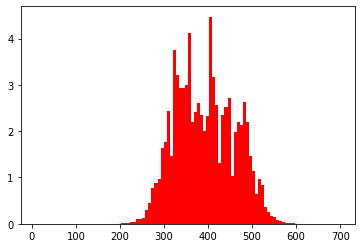

In [9]:
plt.hist(df_e['length'], weights=df_e['test'], density=False, histtype='bar', color='red', bins=100, stacked=True)
plt.show()

In [10]:
df_b['test'] = df_b['length'].map(fragment_comps)
df_b['test'] = df_b['test'] * df_b['probability']

df_b[df_b['length']==500]

,seq,start,end,m1,m2,internal,length,reverse,probability,test
4660,CATGATGGCTCCCATCAGAAGATGCCAGGCATTCATATGAATGATA...,786444,786940,GAATTC,CATG,2,500,1,0.011719,0.007617
4661,CATGGCGTTTACCGCGCTTTCCGTTTGTGCGATATGCTTGGCCAGA...,2612276,2612770,CATG,GAATTC,4,500,0,0.000732,0.000476
4662,CATGTTGCTTACCGAACCATACCGGAGTGTATAGATGCGGCAGTTG...,1393979,1394475,GAATTC,CATG,3,500,1,0.002930,0.001904
4663,CATGCTGCCGTTACGAGATCAGTGAGAGGAATCAAAGAGACACAAA...,551429,551923,CATG,GAATTC,1,500,0,0.046875,0.030469
4664,CATGCTCCGGCGCCCTCCTGACATGTTTGTATTCACTTTCTAACTC...,3284688,3285182,CATG,GAATTC,1,500,0,0.046875,0.030469
4665,CATGATCTTCAAGTAAAACAACTTACTCCAAATATTTGTAAGAACA...,1841508,1842002,CATG,GAATTC,1,500,0,0.046875,0.030469
4666,CATGACTTTTGGTAGCTTATAAAAAGAACTCCCTTCAACTGCTGCT...,3315262,3315756,CATG,GAATTC,2,500,0,0.011719,0.007617
4667,CATGCGGGGTGACACCACAAGCCGTGGCTATGAATGTAAAACCTGA...,3236631,3237125,CATG,GAATTC,3,500,0,0.002930,0.001904
4668,CATGCTCAGCGATATGTTCTGCATATTGTGCAGGCGGTGTATTTTC...,3902680,3903174,CATG,GAATTC,3,500,0,0.002930,0.001904
4669,CATGGATGCCTGATATGGGAATGGATAAAGCGGCCTCTGCAGGAAA...,3247295,3247789,CATG,GAATTC,0,500,0,0.187500,0.121875


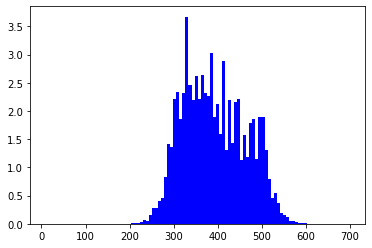

In [11]:
plt.hist(df_b['length'], weights=df_b['test'], density=False, histtype='bar', color='blue', bins=100, stacked=True)
plt.show()

In [12]:
new_fragments_freq_b = {}

for i in range(0, max(df_b['length'])+1):
    new_fragments_freq_b[i] = df_b[df_b['length'] == i]['test'].sum()

new_fragments_freq_e = {}

for i in range(0, max(df_e['length'])+1):
    new_fragments_freq_e[i] = df_e[df_e['length'] == i]['test'].sum()

new_fragments_freq = {i:new_fragments_freq_b[i]+new_fragments_freq_e[i] for i in range(0, 701)}

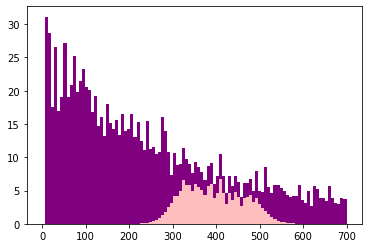

In [13]:
plt.hist(fragments_freq.keys(), weights=fragments_freq.values(), density=False, histtype='bar', color='purple', bins=100, stacked=True)
plt.hist(new_fragments_freq.keys(), weights=new_fragments_freq.values(), density=False, histtype='bar', color='red', bins=100, stacked=True)
plt.hist(draw_dt.keys(), weights=draw_dt.values(), density=False, histtype='bar', color='white', bins=100, stacked=True, alpha=0.75)
plt.show()

Now, to distribute n total reads across the two organisms:

In [14]:
sum(draw_dt.values())

154.27333951952448

In [15]:
n = 400000000
adjustment = n / sum(draw_dt.values())
adjustment

2592800.55287438

In [16]:
df_e['test'] = df_e['length'].map(fragment_comps)
df_e['test'] = round(df_e['test'] * df_e['probability'] * adjustment)

df_e[df_e['length']==500]

,seq,start,end,m1,m2,internal,length,reverse,probability,test
2378,CATGGATCCAGTATCAGGGATTCAAAACCGAAATCGACAAACACAT...,1128114,1128608,CATG,GAATTC,0,500,0,0.375000,631995.0
2379,CATGCTCAACGCGGTACTCGCTCTGGTAATTCGCGTTGTAAATAGC...,1798608,1799102,CATG,GAATTC,3,500,0,0.005859,9875.0


In [17]:
df_b['test'] = df_b['length'].map(fragment_comps)
df_b['test'] = round(df_b['test'] * df_b['probability'] * adjustment)

df_b[df_b['length']==500]

,seq,start,end,m1,m2,internal,length,reverse,probability,test
4660,CATGATGGCTCCCATCAGAAGATGCCAGGCATTCATATGAATGATA...,786444,786940,GAATTC,CATG,2,500,1,0.011719,19750.0
4661,CATGGCGTTTACCGCGCTTTCCGTTTGTGCGATATGCTTGGCCAGA...,2612276,2612770,CATG,GAATTC,4,500,0,0.000732,1234.0
4662,CATGTTGCTTACCGAACCATACCGGAGTGTATAGATGCGGCAGTTG...,1393979,1394475,GAATTC,CATG,3,500,1,0.002930,4937.0
4663,CATGCTGCCGTTACGAGATCAGTGAGAGGAATCAAAGAGACACAAA...,551429,551923,CATG,GAATTC,1,500,0,0.046875,78999.0
4664,CATGCTCCGGCGCCCTCCTGACATGTTTGTATTCACTTTCTAACTC...,3284688,3285182,CATG,GAATTC,1,500,0,0.046875,78999.0
4665,CATGATCTTCAAGTAAAACAACTTACTCCAAATATTTGTAAGAACA...,1841508,1842002,CATG,GAATTC,1,500,0,0.046875,78999.0
4666,CATGACTTTTGGTAGCTTATAAAAAGAACTCCCTTCAACTGCTGCT...,3315262,3315756,CATG,GAATTC,2,500,0,0.011719,19750.0
4667,CATGCGGGGTGACACCACAAGCCGTGGCTATGAATGTAAAACCTGA...,3236631,3237125,CATG,GAATTC,3,500,0,0.002930,4937.0
4668,CATGCTCAGCGATATGTTCTGCATATTGTGCAGGCGGTGTATTTTC...,3902680,3903174,CATG,GAATTC,3,500,0,0.002930,4937.0
4669,CATGGATGCCTGATATGGGAATGGATAAAGCGGCCTCTGCAGGAAA...,3247295,3247789,CATG,GAATTC,0,500,0,0.187500,315998.0


In [18]:
new_fragments_freq_b = {}

for i in range(0, max(df_b['length'])+1):
    new_fragments_freq_b[i] = df_b[df_b['length'] == i]['test'].sum()

new_fragments_freq_e = {}

for i in range(0, max(df_e['length'])+1):
    new_fragments_freq_e[i] = df_e[df_e['length'] == i]['test'].sum()

new_fragments_freq = {i:new_fragments_freq_b[i]+new_fragments_freq_e[i] for i in range(0, 701)}

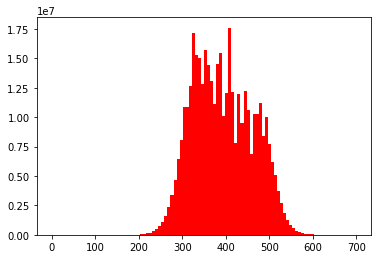

In [19]:
plt.hist(new_fragments_freq.keys(), weights=new_fragments_freq.values(), density=False, histtype='bar', color='red', bins=100, stacked=True)
plt.show()

After rounding, how far are the total reads from the target?

In [24]:
print(f'{round(n - sum(new_fragments_freq.values())):,} reads away from target of {n:,}')

43 reads away from target of 400,000,000


In percent:

In [22]:
print(f'{((n - sum(new_fragments_freq.values()))/n)*100} % off target')

1.075e-05 % off target


After implementing the approach outlined above, the 18 ATCC and Zymo organisms were simulated under the following conditions:
- -m1 hhai
- -m2 msei
- -l 150
- -n 12000000
- -mean 400
- -up_bound 500
- -cut_prob 0.75
- -o output
- -genome rel_path_metagenome.csv
- -a1 ~/github/read_simulation/raw_data/adapters/kuster_ddRADseq/for_hhai.txt
- -a2 ~/github/read_simulation/raw_data/adapters/kuster_ddRADseq/rev_msei.txt

The *rel_path_metagenome.csv* file has each organism comprising 1/18 of the total solution.

10


No handles with labels found to put in legend.


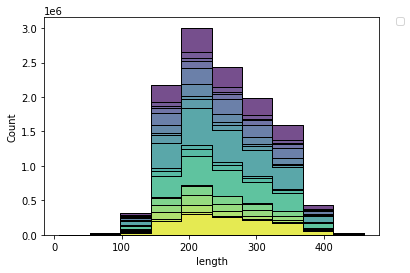

20


No handles with labels found to put in legend.


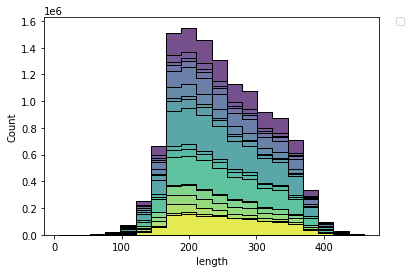

30


No handles with labels found to put in legend.


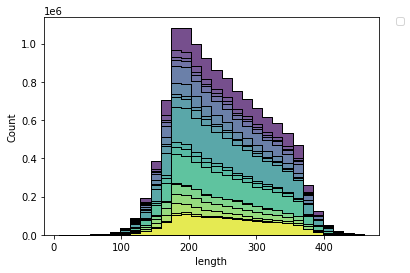

40


No handles with labels found to put in legend.


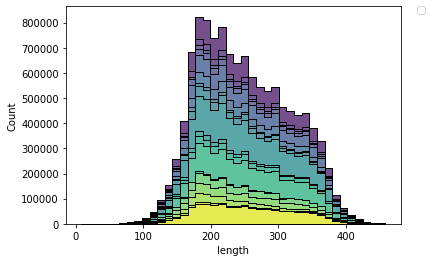

50


No handles with labels found to put in legend.


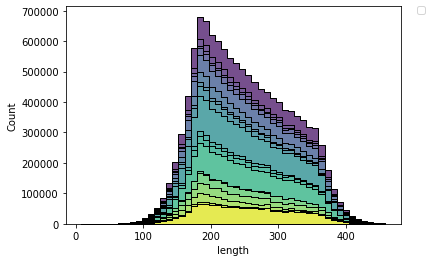

60


No handles with labels found to put in legend.


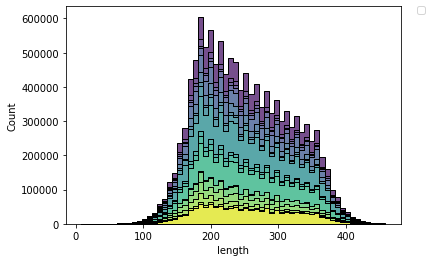

70


No handles with labels found to put in legend.


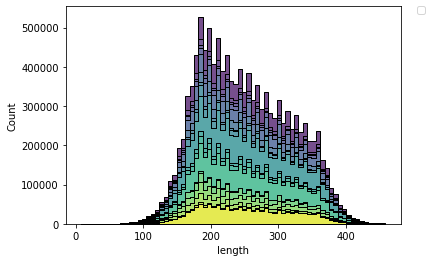

80


No handles with labels found to put in legend.


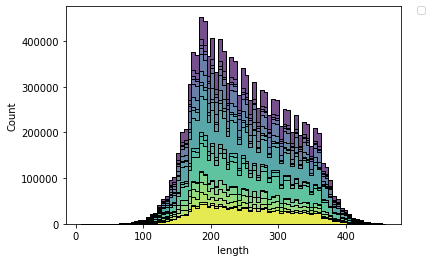

90


No handles with labels found to put in legend.


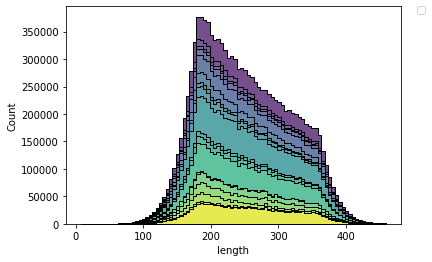

In [64]:
total_freqs = pd.read_csv('../tests/test_metagenome0/test.csv')
for bin_test in range(10, 100, 10):
    print(bin_test)
    sns.histplot(data=total_freqs, x=total_freqs['length'], hue=total_freqs['name'], weights=total_freqs['test'], palette="viridis", multiple="stack", bins=bin_test, element="step")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [57]:
total_freqs = total_freqs.dropna()
total_freqs = total_freqs[total_freqs['test'] > 0]
total_freqs['length'].max() - total_freqs['length'].min()

435

In [13]:
import cProfile
import pstats

In [26]:
profile = cProfile.Profile()
func_to_test = '''gauss_pdf(500, 50, 525)'''
profile.run(func_to_test)
ps = pstats.Stats(profile)
ps.print_stats()

         4 function calls in 0.000 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 <ipython-input-12-5436b7e68527>:1(gauss_pdf)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)




```
546     import cProfile, pstats #TODO #TODO
547     profiler = cProfile.Profile() #TODO #TODO #TODO
548     profiler.enable() #TODO #TODO #TODO
 

CODE


553     profiler.disable() #TODO #TODO
554     stats = pstats.Stats(profiler).sort_stats('ncalls') #TODO
555     stats.print_stats() #TODO
556     sys.exit()  #TODO #TODO #TODO #TODO #TODO #TODO


```